# ASMSA: Tune AAE model hyperparameters

**Previous step**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files

**Next steps**
- [train.ipynb](train.ipynb): Use results of previous tuning in more thorough training
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2024-11-05 08:47:47.380904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 08:47:47.394377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 08:47:47.398398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 08:47:47.411368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 08:47:48.097786: W tensorflow/compiler/tf2

In [2]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa
from datetime import datetime
import tensorflow as tf

2024-11-05 08:47:50.580545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8098 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [3]:
exec(open('inputs.py').read())

## Load dataset

In [4]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')
X_train_np = np.stack(list(X_train))
X_train_np = X_train_np[:int(0.5*len(X_train_np))]

# load validation dataset
X_validate = tf.data.Dataset.load('datasets/intcoords/validate')
X_validate_np = np.stack(list(X_validate))

X_train_np.shape, X_validate_np.shape

2024-11-05 08:47:53.300649: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-05 08:47:54.144829: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((17299, 1419), (7500, 1419))

## Hyperparameter definition
Specify hyperparameter ranges

In [11]:
medium_hp = {
    'activation' : ['gelu','selu'],
    'ae_neuron_number_seed' : [32,96,128],
    'disc_neuron_number_seed' : [32,96],
    'ae_number_of_layers' : [2,5],
    'disc_number_of_layers' : [2,5],
    'batch_size' : [64,128,256],
    'optimizer' : ['Adam'],
    'learning_rate' : 0.0002,
    'ae_loss_fn' : ['Huber'],
    'disc_loss_fn' : ['BinaryCrossentropy']
}


## Sequential hyperparameter tuning

This is robust, it does not require Kubernetes environment for additional job submission but GPU is strongly recommended in the notebook itself to get reasonable speed, not requiring the following (currently broken) parallel tuning section.


In [12]:
# Just testing numbers of epochs and hyperparameter setting trials
# Don't expect anything meaningful
trials=50
epochs=30

# Set RESULTS_DIR env variable for results of tuning
os.environ['RESULTS_DIR'] = datetime.today().strftime("%m%d%Y-%H%M%S")
tuner = keras_tuner.RandomSearch(
    max_trials=trials,
    hypermodel=
        asmsa.AAEHyperModel(
            (X_validate_np.shape[1],),
            hp=medium_hp,
            prior=tfp.distributions.Normal(loc=0, scale=1)),
    objective=keras_tuner.Objective("score", direction="min"),
    directory="./results",
    project_name="Random",
    overwrite=True
)

In [13]:
tuner.search(train=X_train_np,validation=X_validate_np,epochs=epochs,verbose=2)

Trial 2 Complete [00h 00m 22s]

Best score So Far: None
Total elapsed time: 00h 00m 44s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
selu              |selu              |activation
2                 |5                 |ae_number_of_layers
2                 |2                 |disc_number_of_layers
256               |256               |batch_size
Adam              |Adam              |optimizer
0.0002            |0.0002            |learning_rate
Huber             |Huber             |ae_loss_fn
BinaryCrossentropy|BinaryCrossentropy|disc_loss_fn

Trial ID: ab634b15754d96caf051ed35cbb628dd6c2ccb4f64ca85931081aa9bc6805386
Epoch 1/30
......


2024-11-05 09:17:51.188972: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 243.59MiB (rounded to 255420160)requested by op Abs
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-05 09:17:51.189139: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-11-05 09:17:51.189157: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 3150, Chunks in use: 3149. 787.5KiB allocated for chunks. 787.2KiB in use in bin. 121.7KiB client-requested in use in bin.
2024-11-05 09:17:51.189165: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 657, Chunks in use: 657. 383.0KiB allocated for chunks. 383.0KiB in use in bin. 354.8KiB client-requested in use in bin.
2024-11-05 0

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/asmsa/aae_hyper_model.py", line 212, in fit
    super().fit(hp, model, train, callbacks=callbacks + [logcb], **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/lib/python3.10/site-packages/asmsa/aae_hyper_model.py", line 116, in on_epoch_end
    mse = self.model.ae_loss_fn(self.multibatch,reconstruct[0])
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__Abs_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Abs] name: 


In [14]:
from asmsa.tuning_analyzer import TuningAnalyzer

# Create analyzer object that analyses results of tuning
# By default it is the latest tuning, but can by choosen with tuning flag,
#  e.g TuningAnalyzer(tuning='analysis/05092023-135249')
analyzer = TuningAnalyzer()

Analyzing tuning from: /home/jovyan/ASMSA/analysis/09152024-062740/


In [15]:
# Get sorted hyperparameters by score, by default 10 best HP, for different number:
#  analyzer.get_best_hp(num_trials=3)
analyzer.get_best_hp()

Printing results of tuning: /home/jovyan/ASMSA/analysis/09152024-062740/
-----(1)-----
Trial ID: af0a1be1bc6e6b34943556cfaaf5329e63d7a224f8e4aa892d62b941673839f3
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.15383518146453173
-----(2)-----
Trial ID: abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 2
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.18225192744528268
-----(3)-----
Trial ID: b2c0e33e1bc5ab4528251267d0f562aaabc06e4e25a736d0da8e0167833e1feb
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 512
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.18927

Trial ID: af0a1be1bc6e6b34943556cfaaf5329e63d7a224f8e4aa892d62b941673839f3


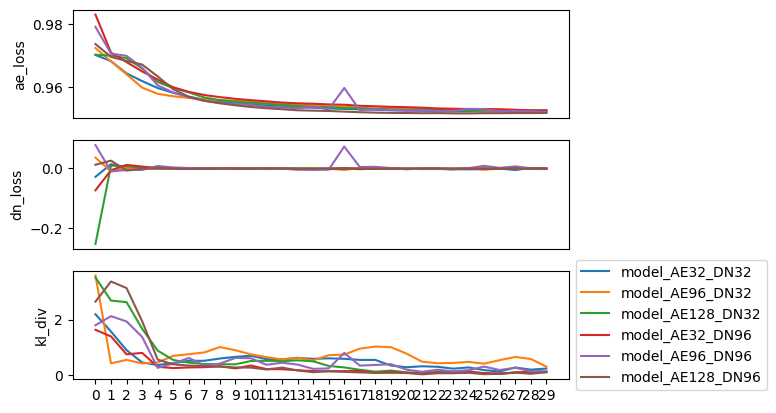

Trial ID: abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa


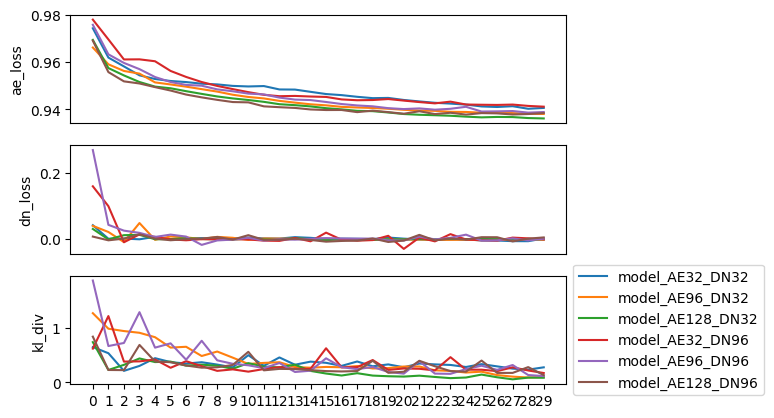

Trial ID: b2c0e33e1bc5ab4528251267d0f562aaabc06e4e25a736d0da8e0167833e1feb


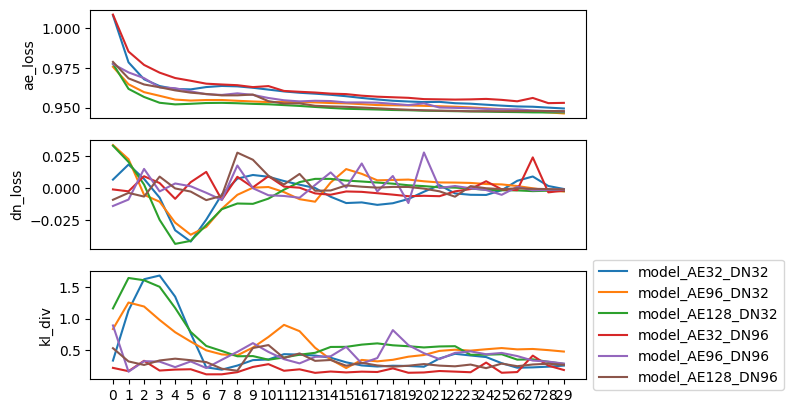

Trial ID: 321941fd98328131ed16c88a036bd55f1e2f9b1b55436ff849229965476e3183


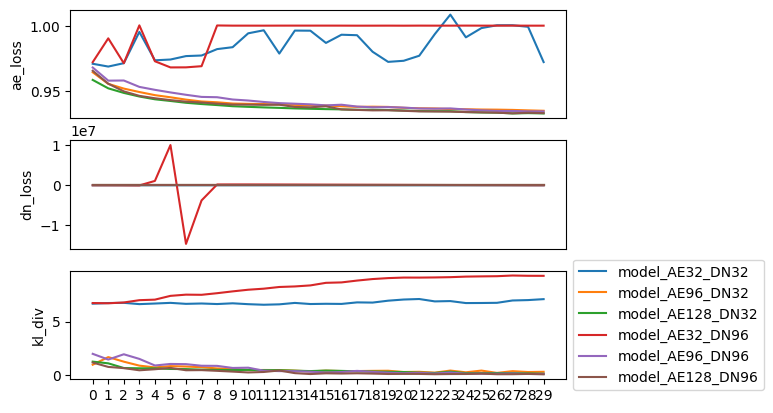

Trial ID: 7207e8e465d470e3bba8a77e83243b55b5a97e75fa21ccb2dc65a7cc9667d8f3


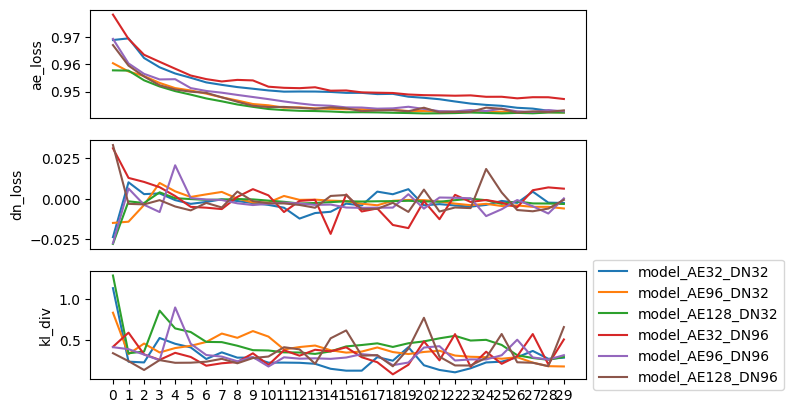

Trial ID: 132d5e318c9709cfe45fef09143f6de2c036c61aa574ba5d89b85e1d6c8494bc


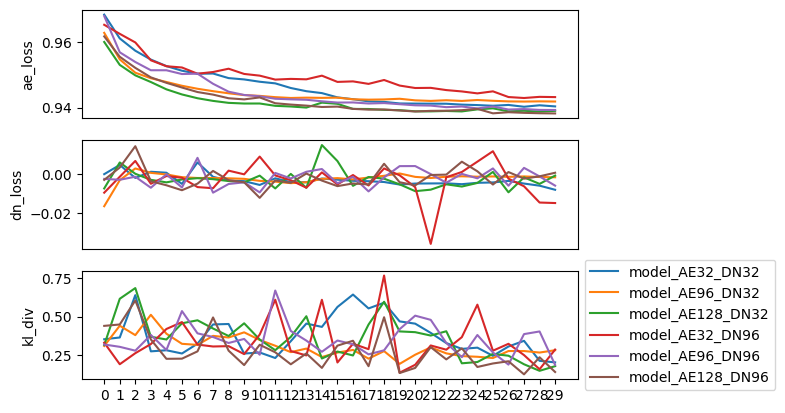

Trial ID: 914770411af3ce7a4a86b84c321f29beca78654da0cf07d104b831706d76f92c


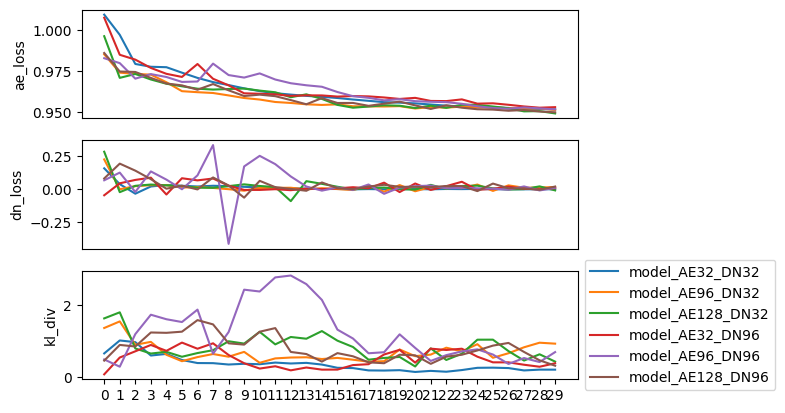

Trial ID: ab1c5219a15d550750015c888f6d0918c7ab6ab785c01ba659e9a170aa245401


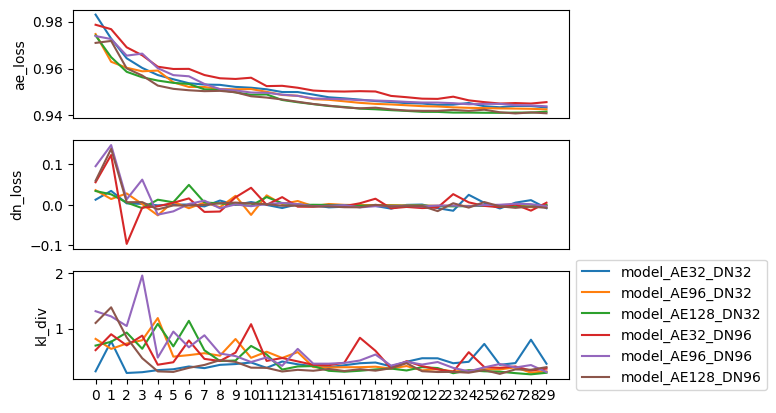

Trial ID: f68d73dce1e4ca313a7a3e7b283b0226429bb48423919dff435881888315a4c9


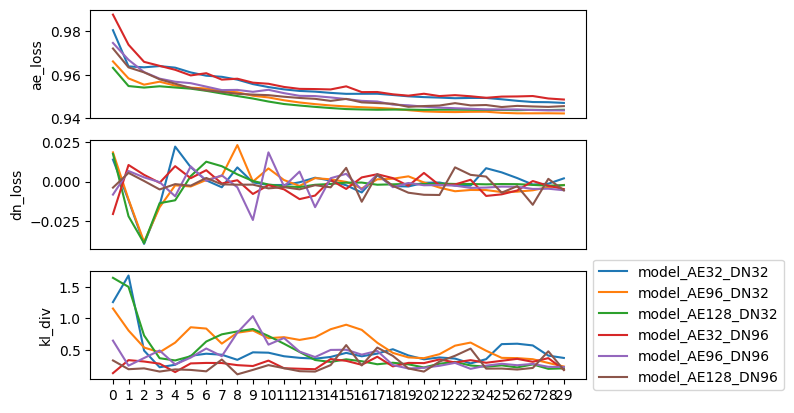

Trial ID: db2ebfb0475068e7e9b95dba14bc55bba95da489fdbe897921763efe3f01fa4d


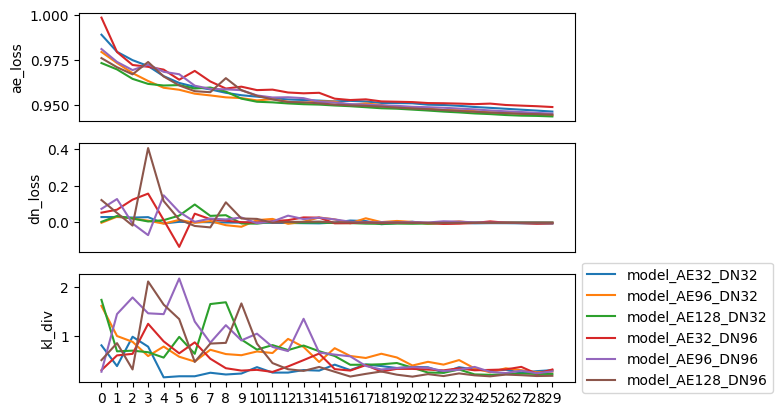

In [16]:
# Matplotlib visualization - not recommended way, does not look that good and does not scale 
#  that well but at least the colors are consistent accross measures. After more work could look better
# - By default visualizing best 10 trials
# - Can specify only one specific trial... analyzer.visualize_tuning(trial='15d9fa928a7517004bcb28771bb6e5f17ad66dd7013c6aa1572a84773d91393c')
# - Can specify number of best trials to be visualized... analyzer.visualize_tuning(num_trials=3)
analyzer.visualize_tuning()

In [ ]:
# Recommended option via Tensorboard. This function populates TB event
#  which can be viewed in native way via Tensorboard. 
# May not work in all Jupyterhub setups, though.

# By default it chooses latest tuning and populates into its directory _TB, e.g: analysis/05092023-135249/_TB
# - Can override directory where to populate... analyzer.populate_TB(out_dir='MyTBeventDir')
# - Can choose only specific trials via list... analyzer.populate_TB(trials=['15d9fa928a7517004bcb28771bb6e5f17ad66dd7013c6aa1572a84773d91393c']),
# - Can select how many best trials to be visualized... analyzer.populate_TB(num_trials=3)
analyzer.populate_TB(num_trials=3)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir analysis

## Parallel hyperparameter tuning

**BROKEN**, ignore the rest of this notebook for the time being

In [ ]:
# Finally, this is the real stuff
# medium settings known to be working for trpcage

epochs=15
trials=3
hp=medium_hp

# testing only
#epochs=8
#trials=6
#hp=tiny_hp

In [ ]:
# number of parallel workers, each runs a single trial at time
# balance between resource availability and size of the problem
# currently each slave runs on 4 cores and 4 GB RAM (hardcoded in src/asmsa/tunewrapper.py)

slaves=3

In [ ]:
# XXX: Kubernetes magic: find out names of container image and volume
# check the result, it can go wrong

with open('IMAGE') as img:
    image=img.read().rstrip()

import re
mnt=os.popen('mount | grep /home/jovyan').read()
pvcid=re.search('pvc-[0-9a-z-]+',mnt).group(0)
pvc=os.popen(f'kubectl get pvc | grep {pvcid} | cut -f1 -d" "').read().rstrip()

print(f"""\
image: {image}
volume: {pvc}
""")

In [ ]:
# Python wrapper around scripts that prepare and execute parellel Keras Tuner in Kubernetes
from asmsa.tunewrapper import TuneWrapper

wrapper = TuneWrapper(ds=X_validate_np,hp=hp,output=datetime.today().strftime("%m%d%Y-%H%M%S"),epochs=epochs,trials=trials,pdb=conf,top=topol,xtc=traj,ndx=index, pvc=pvc)

In [ ]:
# Necessary but destructive cleanup before hyperparameter tuning

# DON'T RUN THIS CELL BLINDLY
# it kills any running processes including the workers, and it purges previous results

!kubectl delete job/tuner
!kill $(ps ax | grep tuning.py | awk '{print $1}')
!rm -rf results

In [ ]:
# start the master (chief) of tuners in background
# the computation takes rather long, this is a more robust approach then keeping it in the notebook

wrapper.master_start()

In [ ]:
# therefore one should check the status ocassionally; it should show a tuning.py process running
print(wrapper.master_status())

In [ ]:
# spawn the requested number of workers as separate Kubernetes job with several pods 
# they receive work from 

wrapper.workers_start(num=slaves)

In [ ]:
# This status should show {slaves} number of pods, all of them start in Pending state, and follow through ContainerCreating 
# to Running, and Completed finally

# This takes time, minutes to hours depending on size of the model, number of trials, and number of slaves
# Run this cell repeatedly, waiting until all the pods are completed

wrapper.workers_status()

In [ ]:
# Same steps for analysis as with serial tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp()

In [ ]:
# We can choose output dir for TB event this time
out = 'dist_tuning'

analyzer.populate_TB(out_dir=out)

In [ ]:
# Might need to kill previous tensorboard instance to change logdir
!pkill -f 'tensorboard'

%load_ext tensorboard
%tensorboard --logdir $out